In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from datetime import datetime
from scipy.stats import pearsonr, ttest_ind
from sklearn.preprocessing import MinMaxScaler


In [2]:
mdata = pd.read_csv("mdata.csv")

In [3]:
mdata

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
0,2018-10-17,1,1000,1,5,natural chips compny seasalt175g,2,6.0,175.0,NATURAL,YOUNG SINGLES/COUPLES,Premium
1,2019-05-14,1,1307,348,66,ccs nacho cheese 175g,3,6.3,175.0,CCS,MIDAGE SINGLES/COUPLES,Budget
2,2019-05-20,1,1343,383,61,smiths crinkle cut chips chicken 170g,2,2.9,170.0,SMITHS,MIDAGE SINGLES/COUPLES,Budget
3,2018-08-17,2,2373,974,69,smiths chips thinly s/cream&onion 175g,5,15.0,175.0,SMITHS,MIDAGE SINGLES/COUPLES,Budget
4,2018-08-18,2,2426,1038,108,kettle tortilla chpshny&jlpno chili 150g,3,13.8,150.0,KETTLE,MIDAGE SINGLES/COUPLES,Budget
...,...,...,...,...,...,...,...,...,...,...,...,...
246735,2019-03-09,272,272319,270088,89,kettle sweet chilli and sour cream 175g,2,10.8,175.0,KETTLE,YOUNG SINGLES/COUPLES,Premium
246736,2018-08-13,272,272358,270154,74,tostitos splash of lime 175g,1,4.4,175.0,TOSTITOS,YOUNG SINGLES/COUPLES,Premium
246737,2018-11-06,272,272379,270187,51,doritos mexicana 170g,2,8.8,170.0,DORITOS,YOUNG SINGLES/COUPLES,Premium
246738,2018-12-27,272,272379,270188,42,doritos corn chips mexican jalapeno 150g,2,7.8,150.0,DORITOS,YOUNG SINGLES/COUPLES,Premium


In [4]:
mdata['DATE'] = pd.to_datetime(mdata['DATE'])
mdata['MONTH']=mdata['DATE'].dt.month

In [5]:
monthly_metrics = mdata.groupby(['STORE_NBR', 'MONTH']).agg(
    total_sales=('TOT_SALES', 'sum'),
    total_customers=('LYLTY_CARD_NBR', lambda x: x.nunique()),
    transactions_per_customer=('LYLTY_CARD_NBR', lambda x: x.count()/x.nunique())
).reset_index()



In [6]:
MONTH_ORDER = {7: 1, 8: 2, 9: 3, 10: 4, 11: 5, 12: 6, 1: 7, 2: 8, 3: 9, 4: 10, 5: 11, 6: 12}
monthly_metrics['MONTH_ORDER'] = monthly_metrics['MONTH'].map(MONTH_ORDER)
monthly_metrics = monthly_metrics.sort_values(['STORE_NBR', 'MONTH_ORDER'])
# monthly_metrics = monthly_metrics.drop(columns=['MONTH_ORDER'])
monthly_metrics = monthly_metrics.reset_index(drop=True)

In [7]:
monthly_metrics

,STORE_NBR,MONTH,total_sales,total_customers,transactions_per_customer,MONTH_ORDER
0,1,7,188.9,47,1.042553,1
1,1,8,168.4,41,1.000000,2
2,1,9,268.1,57,1.035088,3
3,1,10,175.4,39,1.025641,4
4,1,11,184.8,44,1.022727,5
...,...,...,...,...,...,...
3160,272,2,385.3,44,1.068182,8
3161,272,3,421.9,48,1.062500,9
3162,272,4,445.1,54,1.037037,10
3163,272,5,314.6,34,1.176471,11


In [8]:
trial_metrics = monthly_metrics[monthly_metrics['STORE_NBR'] == 77].sort_values('MONTH')
control_metrics = monthly_metrics[monthly_metrics['STORE_NBR'] == 86].sort_values('MONTH')
merged = pd.merge(trial_metrics, control_metrics, on='MONTH', suffixes=('_trial', '_control'))
merged

,STORE_NBR_trial,MONTH,total_sales_trial,total_customers_trial,transactions_per_customer_trial,MONTH_ORDER_trial,STORE_NBR_control,total_sales_control,total_customers_control,transactions_per_customer_control,MONTH_ORDER_control
0,77,1,188.4,31,1.129032,7,86,800.60,89,1.359551,7
1,77,2,211.6,40,1.000000,8,86,872.80,105,1.247619,8
2,77,3,255.1,46,1.108696,9,86,945.40,108,1.185185,9
3,77,4,258.1,47,1.000000,10,86,804.00,99,1.212121,10
4,77,5,272.3,53,1.018868,11,86,826.90,99,1.191919,11
5,77,6,246.6,38,1.026316,12,86,766.00,92,1.195652,12
6,77,7,268.4,47,1.085106,1,86,851.00,94,1.276596,1
7,77,8,247.5,46,1.000000,2,86,726.85,92,1.152174,2
8,77,9,216.8,40,1.050000,3,86,855.00,100,1.210000,3
9,77,10,194.3,36,1.027778,4,86,898.80,105,1.238095,4


In [9]:
def calculate_similarity(trial_store, metric_df):   

    trial_metrics = metric_df[metric_df['STORE_NBR'] == trial_store].sort_values('MONTH')
    # First, collect all differences to normalize across all stores
    all_diffs = []

    for store in metric_df['STORE_NBR'].unique():
        if store == trial_store:
            continue

        control_metrics = metric_df[metric_df['STORE_NBR'] == store].sort_values('MONTH')
        if len(control_metrics) < 12:  # filter to reach stores that are operational for the entire observation period.
            continue

        merged = pd.merge(trial_metrics, control_metrics, on='MONTH', suffixes=('_trial', '_control'))
        merged = merged[merged['MONTH'].isin([7,8,9,10,11,12,1,2])]
        
        # Calculate differences for this store
        diff = abs(merged['total_customers_trial'] - merged['total_customers_control'])
        all_diffs.extend(diff.tolist())



    # Now calculate scores with global normalization

    control_scores = []
    for store in metric_df['STORE_NBR'].unique():
        if store == trial_store:
            continue

        control_metrics = metric_df[metric_df['STORE_NBR'] == store].sort_values('MONTH')
        if len(control_metrics) < 12:
            continue

        merged = pd.merge(trial_metrics, control_metrics, on='MONTH', suffixes=('_trial', '_control'))
        merged = merged[merged['MONTH'].isin([7,8,9,10,11,12,1,2])]
        # Global normalization
        global_min = min(all_diffs)
        global_max = max(all_diffs)

        corr, _ = pearsonr(merged['total_customers_trial'], merged['total_customers_control'])
        corr_score = max(0, corr)   # just positive indicator
        diff = abs(merged['total_customers_trial'] - merged['total_customers_control'])
        mag = 1 - (diff - global_min) / (global_max-global_min)
        mag_score = mag.mean()
        final_score = (1.0*corr_score + 0.0*mag_score)  # positive indicator, the higher the more similar
        control_scores.append((store, final_score))

    best_match2 = sorted(control_scores, key=lambda x: x[1], reverse=True)[0]
    return best_match2


the code bellow is just inside of the function above for testing the results:

In [10]:
trial_metrics = monthly_metrics[monthly_metrics['STORE_NBR'] == 77].sort_values('MONTH')
# First, collect all differences to normalize across all stores
all_diffs = []

for store in monthly_metrics['STORE_NBR'].unique():
    if store == 77:
        continue

    control_metrics = monthly_metrics[monthly_metrics['STORE_NBR'] == store].sort_values('MONTH')
    if len(control_metrics) < 12:  # filter to reach stores that are operational for the entire observation period.
        continue

    merged = pd.merge(trial_metrics, control_metrics, on='MONTH', suffixes=('_trial', '_control'))
    merged = merged[merged['MONTH'].isin([7,8,9,10,11,12,1,2])]
    
    # Calculate differences for this store
    diff = abs(merged['total_customers_trial'] - merged['total_customers_control'])
    all_diffs.extend(diff.tolist())



# Now calculate scores with global normalization

control_scores = []
for store in monthly_metrics['STORE_NBR'].unique():
    if store == 77:
        continue

    control_metrics = monthly_metrics[monthly_metrics['STORE_NBR'] == store].sort_values('MONTH')
    if len(control_metrics) < 12:
        continue

    merged = pd.merge(trial_metrics, control_metrics, on='MONTH', suffixes=('_trial', '_control'))
    merged = merged[merged['MONTH'].isin([7,8,9,10,11,12,1,2])]
    # Global normalization
    global_min = min(all_diffs)
    global_max = max(all_diffs)

    corr, _ = pearsonr(merged['total_customers_trial'], merged['total_customers_control'])
    corr_score = max(0, corr)   # just positive indicator
    diff = abs(merged['total_customers_trial'] - merged['total_customers_control'])
    mag = 1 - (diff - global_min) / (global_max-global_min)
    mag_score = mag.mean()
    final_score = (1.0*corr_score + 0.0*mag_score)  # positive indicator, the higher the more similar
    control_scores.append((store, final_score))

best_match2 = sorted(control_scores, key=lambda x: x[1], reverse=True)
best_match2


[(233, 0.9498158264965949),
 (35, 0.8906242127017729),
 (119, 0.8675929858944993),
 (88, 0.8575675519626931),
 (237, 0.8475753218276002),
 (254, 0.8227373094391401),
 (178, 0.7818331318339174),
 (162, 0.7817018981402759),
 (14, 0.7653397582284173),
 (157, 0.7571570673631272),
 (57, 0.7242471620158402),
 (27, 0.7052725328266342),
 (250, 0.703497594964563),
 (113, 0.6725782672300435),
 (167, 0.6496299808172611),
 (105, 0.6475912876641325),
 (53, 0.6450569515320959),
 (248, 0.61157671616446),
 (50, 0.6087282308316647),
 (71, 0.5959509288382956),
 (3, 0.5783904597523396),
 (72, 0.5774030272475834),
 (17, 0.5695117368415802),
 (195, 0.5531957764862028),
 (229, 0.5435526277712499),
 (37, 0.5230959240867978),
 (69, 0.5092430276321196),
 (84, 0.5089031170026656),
 (41, 0.49938113014246943),
 (265, 0.49808616729129646),
 (46, 0.47687180786033073),
 (145, 0.45706756450126007),
 (181, 0.4537853549112895),
 (230, 0.44674628754004153),
 (64, 0.4455297032885488),
 (234, 0.4403756754229417),
 (60, 0.

In [11]:
for store in monthly_metrics['STORE_NBR'].unique():
    control_metrics = monthly_metrics[monthly_metrics['STORE_NBR'] == store].sort_values('MONTH')
    if len(control_metrics) < 12:
        print ([store, len(control_metrics)]);

[11, 2]
[31, 2]
[44, 11]
[76, 1]
[85, 1]
[92, 1]
[117, 10]
[177, 11]
[193, 3]
[206, 2]
[218, 11]
[252, 2]


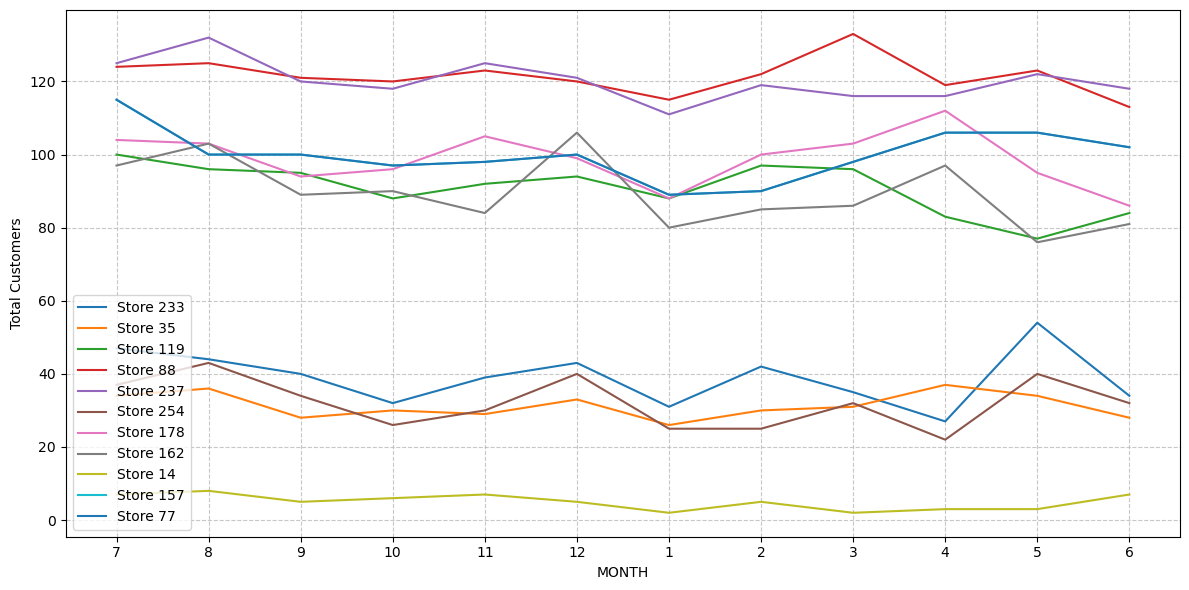

In [12]:
plt.figure(figsize=(12, 6))  # Create a larger figure for better visibility

best_match_dict = dict(best_match2[:10])
for i in best_match_dict.keys():
    # Filter the data for the current store and save it to a variable
    store_data = monthly_metrics[monthly_metrics['STORE_NBR'] == i]
    
    # Plot the total sales for this store
    # This assumes monthly_metrics has a datetime index or a column representing months
    plt.plot(store_data['MONTH_ORDER'], store_data['total_customers'], label=f'Store {i}')
    plt.xticks(store_data['MONTH_ORDER'], store_data['MONTH'])

i = 77
plt.plot(store_data['MONTH_ORDER'], store_data['total_customers'], label=f'Store {i}')

plt.xlabel('MONTH')
plt.ylabel('Total Customers')
plt.legend()
plt.tight_layout()  # Adjust layout to make room for the legend
plt.grid(True, linestyle='--', alpha=0.7)  # Add grid for better readability
plt.show()

### selecting top 10 results from best_match1 and then narrow down to stores within ±25% of the trial store's mean before trial period:

In [ ]:

# Get the top 10 stores from best_match
top_10_stores = best_match2[:10]

# Calculate the mean for trial store (store 77)
trial_mean = monthly_metrics[(monthly_metrics['STORE_NBR'] == 77) & (monthly_metrics['MONTH'].isin([7,8,9,10,11,12,1,2]))]['total_customers'].mean()

# Define the threshold range (±20% of trial mean)
lower_threshold = trial_mean * 0.75  # 30% below
upper_threshold = trial_mean * 1.25  # 30% above

print(f"Trial store (77) mean: {trial_mean:.2f}")
print(f"Threshold range: {lower_threshold:.2f} to {upper_threshold:.2f}")

# Filter top 10 stores to those within the threshold
filtered_stores = []
for store, score in top_10_stores:
    store_mean = monthly_metrics[(monthly_metrics['STORE_NBR'] == store) & (monthly_metrics['MONTH'].isin([7,8,9,10,11,12,1,2]))]['total_customers'].mean()
    if lower_threshold <= store_mean <= upper_threshold:
        filtered_stores.append((store, score, store_mean))

print('...')
print(filtered_stores)


Trial store (77) mean: 40.25
Threshold range: 30.19 to 50.31
...
[(233, 0.9498158264965949, 39.75), (35, 0.8906242127017729, 30.75), (254, 0.8227373094391401, 32.5)]


## T-TEST

Null Hypothesis (H₀): There is no significant difference in the mean number of customers between store #77 and store #233 during the trial period.

In [14]:
trial_period = [2, 3, 4]

trial_data = monthly_metrics[(monthly_metrics['STORE_NBR'] == 77) & 
                                (monthly_metrics['MONTH'].isin(trial_period))]

control_data = monthly_metrics[(monthly_metrics['STORE_NBR'] == 233) & 
                                (monthly_metrics['MONTH'].isin(trial_period))]

# Compare total sales
t_stat, p_val = ttest_ind(trial_data['total_customers'], control_data['total_customers'])

print(f"Trial Store {77} vs Control Store {233}")
print(f"  T-Stat: {t_stat:.2f}, P-Value: {p_val:.4f}")
print(f"  Trial Mean: {trial_data['total_customers'].mean():.2f}, Control Mean: {control_data['total_customers'].mean():.2f}")
print("---")

merged = pd.merge(trial_data, control_data, on='MONTH', suffixes=('_trial', '_control'))

merged

Trial Store 77 vs Control Store 233
  T-Stat: 1.99, P-Value: 0.1172
  Trial Mean: 44.33, Control Mean: 34.67
---


,STORE_NBR_trial,MONTH,total_sales_trial,total_customers_trial,transactions_per_customer_trial,MONTH_ORDER_trial,STORE_NBR_control,total_sales_control,total_customers_control,transactions_per_customer_control,MONTH_ORDER_control
0,77,2,211.6,40,1.000000,8,233,220.7,42,1.023810,8
1,77,3,255.1,46,1.108696,9,233,180.6,35,1.028571,9
2,77,4,258.1,47,1.000000,10,233,144.2,27,1.074074,10


While there appears to be a substantial difference in the average number of customers between store #77 (44.33) and store #233 (34.67), this difference is not statistically significant at 0.1 level.

## But lets check time series plot:

## CONFIDENCE INTERVALS

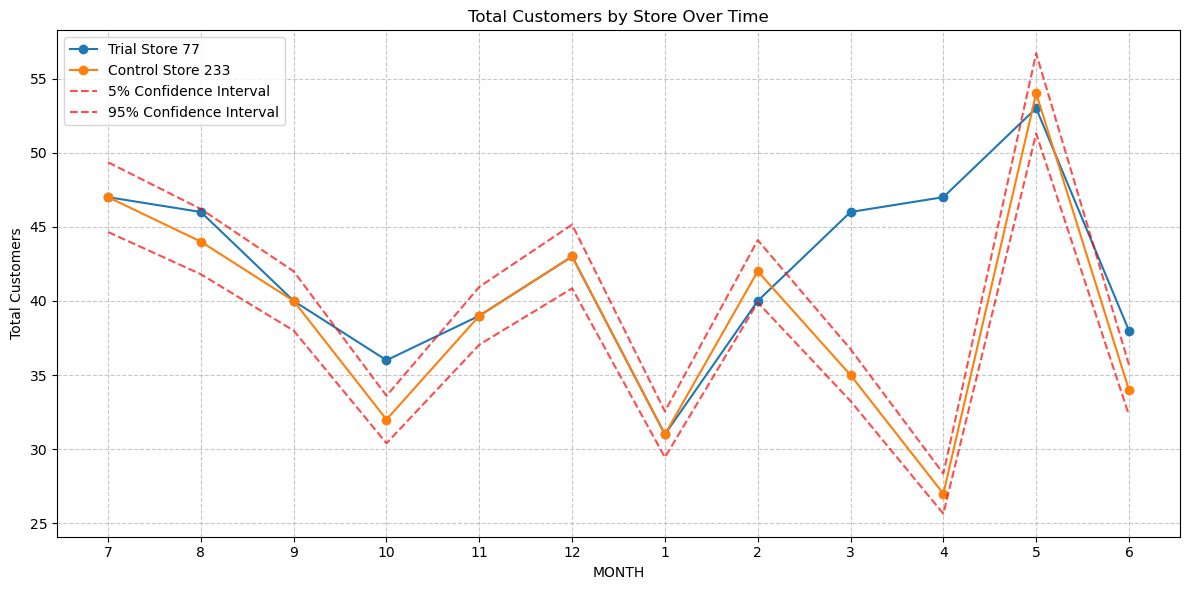

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

plt.figure(figsize=(12, 6))  

trial_store = 77
control_store = 233

trial_data = monthly_metrics[(monthly_metrics['STORE_NBR'] == trial_store)]
plt.plot(trial_data['MONTH_ORDER'], trial_data['total_customers'], label=f'Trial Store {trial_store}', marker='o')


control_data = monthly_metrics[(monthly_metrics['STORE_NBR'] == control_store)]
plt.plot(control_data['MONTH_ORDER'], control_data['total_customers'], label=f'Control Store {control_store}', marker='o')


# Calculating simple Confidence Intervals
confidence_level = 0.05
lower_ci = control_data['total_customers'] * (1 - confidence_level)
upper_ci = control_data['total_customers'] * (1 + confidence_level)


plt.plot(control_data['MONTH_ORDER'], lower_ci, 
         linestyle='--', color='red', alpha=0.7, 
         label='5% Confidence Interval')
plt.plot(control_data['MONTH_ORDER'], upper_ci, 
         linestyle='--', color='red', alpha=0.7, 
         label='95% Confidence Interval')

plt.xticks(trial_data['MONTH_ORDER'], trial_data['MONTH'])
plt.title('Total Customers by Store Over Time')
plt.xlabel('MONTH')
plt.ylabel('Total Customers')
plt.legend()
plt.tight_layout()  
plt.grid(True, linestyle='--', alpha=0.7)  
plt.show()

## Campaign Success Conclusion (control store 233)

The surge we observe in the time series plot is valuable evidence that shouldn't be dismissed simply because the t-test wasn't significant. The t-test has limitations, especially with small samples.

A 27.9% difference in customer count might be highly meaningful from a business perspective, even if it doesn't reach statistical significance with only 3 months of data. so we likely accept the effect of campaign.

## we go for the next control store which will be store 35 based on filtered stores that we calculated previously

T-TEST is useless because the mean number of customer counts in store 35 is obviously lower than store 77. so we wont use T test.

And alternatively we use just confidence intervals

Lets check also the visualitics of time series plot:

## CONFIDENCE INTERVALS

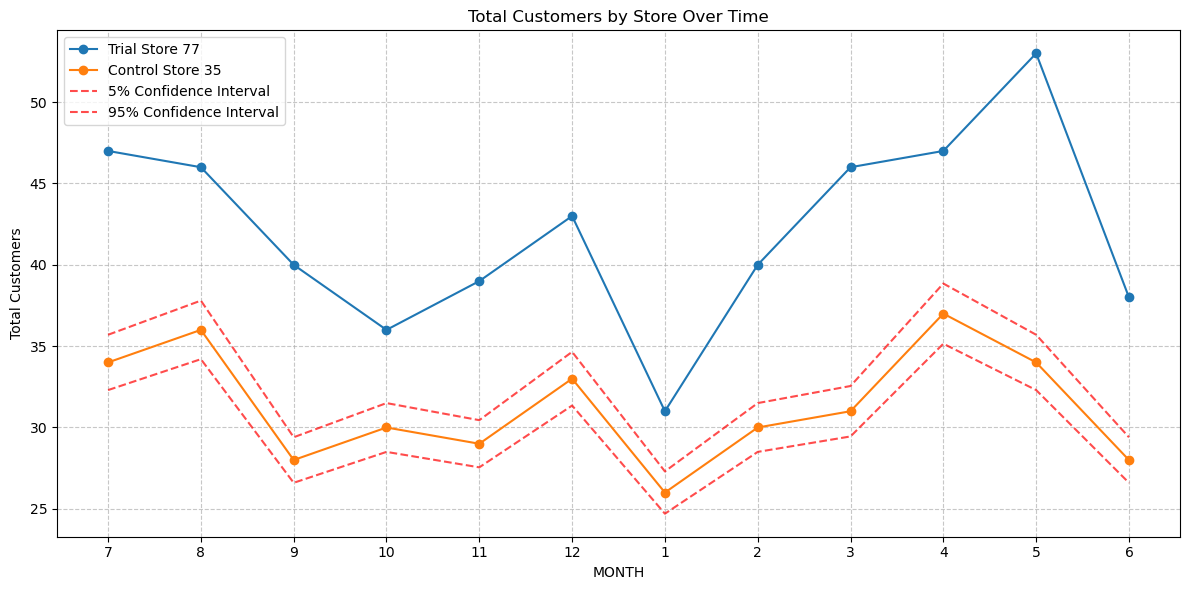

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

plt.figure(figsize=(12, 6))  

trial_store = 77
control_store = 35

trial_data = monthly_metrics[(monthly_metrics['STORE_NBR'] == trial_store)]
plt.plot(trial_data['MONTH_ORDER'], trial_data['total_customers'], label=f'Trial Store {trial_store}', marker='o')


control_data = monthly_metrics[(monthly_metrics['STORE_NBR'] == control_store)]
plt.plot(control_data['MONTH_ORDER'], control_data['total_customers'], label=f'Control Store {control_store}', marker='o')


# Calculating simple Confidence Intervals
confidence_level = 0.05
lower_ci = control_data['total_customers'] * (1 - confidence_level)
upper_ci = control_data['total_customers'] * (1 + confidence_level)


plt.plot(control_data['MONTH_ORDER'], lower_ci, 
         linestyle='--', color='red', alpha=0.7, 
         label='5% Confidence Interval')
plt.plot(control_data['MONTH_ORDER'], upper_ci, 
         linestyle='--', color='red', alpha=0.7, 
         label='95% Confidence Interval')

plt.xticks(trial_data['MONTH_ORDER'], trial_data['MONTH'])
plt.title('Total Customers by Store Over Time')
plt.xlabel('MONTH')
plt.ylabel('Total Customers')
plt.legend()
plt.tight_layout()  
plt.grid(True, linestyle='--', alpha=0.7)  
plt.show()

## Campaign failure Conclusion (control store 35)

We found that both store 35 and 77 showed similar performance surges during the campaign period. The parallel movement in the time series plots indicates that external market factors, not our campaign, likely drove the observed improvements. 

# Final Conclusion on Campaign Effectiveness (Number of customers factor)

The conflicting results from different control stores (233 and 35) highlight the importance of control store selection in retail analytics. With store 233 suggesting campaign success and store 35 indicating no significant impact, our final conclusion must be measured:

The product replacement campaign shows some evidence of positive impact, but this finding is not robust across different control store comparisons. The effectiveness appears to be sensitive to the choice of benchmark, suggesting that the campaign may have had a modest effect that is difficult to distinguish from broader market trends. Additional data or alternative analytical approaches would be needed to make a more definitive determination of campaign success.